<a href="https://colab.research.google.com/github/muhammadsafdar2407/Student-Performance-Predictor/blob/main/Student_Performance_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
spscientist_students_performance_in_exams_path = kagglehub.dataset_download('spscientist/students-performance-in-exams')

print('Data source import complete.')


Using Colab cache for faster access to the 'students-performance-in-exams' dataset.
Data source import complete.


Load the Data and First Look

In [2]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("/kaggle/input/students-performance-in-exams/StudentsPerformance.csv")

# Preview first 5 rows
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


The dataset contains students’ scores in math, reading, and writing, along with demographic information such as gender, parental education level, lunch type, and test preparation course.

Understanding the Dataset

In [3]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


Create target variable and check distribution

In [4]:
score_cols = ['math score', 'reading score', 'writing score']
df['avg_score'] = df[score_cols].mean(axis=1)
df['pass'] = (df['avg_score'] >= 60).astype(int)
df['pass'].value_counts(normalize=True)


,proportion
pass,
1,0.715
0,0.285


Exploratory Data Analysis

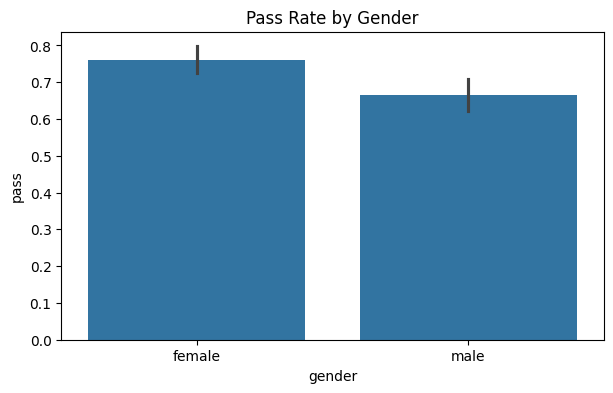

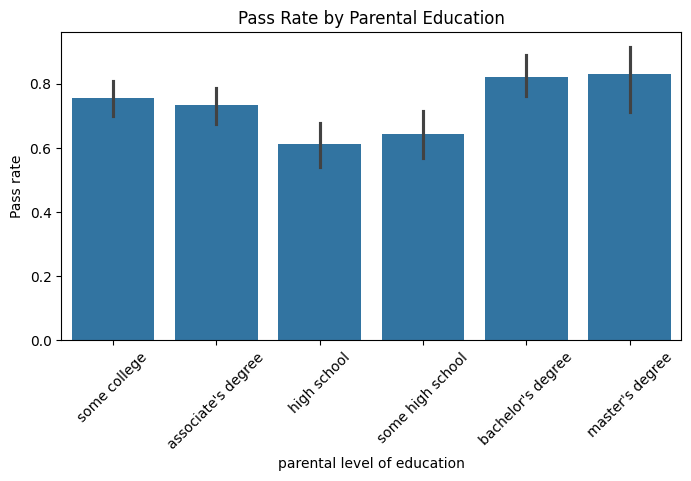

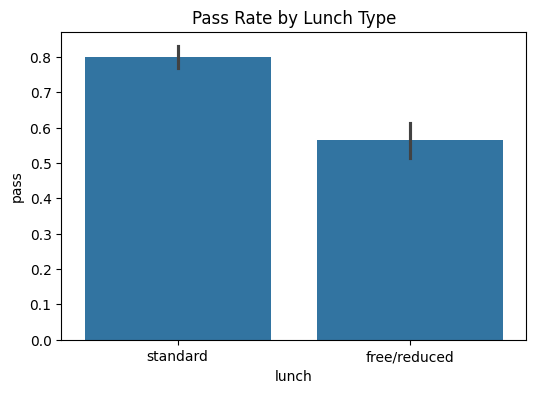

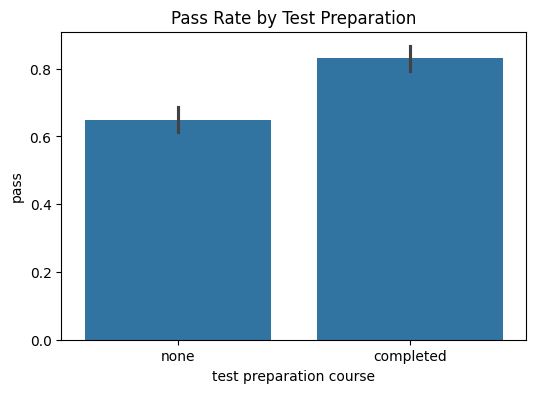

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(7,4))
sns.barplot(x='gender', y='pass', data=df)
plt.title('Pass Rate by Gender')
plt.show()

plt.figure(figsize=(8,4))
order = df['parental level of education'].value_counts().index
sns.barplot(x='parental level of education', y='pass', data=df, order=order)
plt.xticks(rotation=45)
plt.ylabel('Pass rate')
plt.title('Pass Rate by Parental Education')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='lunch', y='pass', data=df)
plt.title('Pass Rate by Lunch Type')
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x='test preparation course', y='pass', data=df)
plt.title('Pass Rate by Test Preparation')
plt.show()

Train/Test split and preprocessing pipeline

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

cat_features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

X = df[cat_features]
y = df['pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('cat', cat_transformer, cat_features)
])


Baseline models: Logistic Regression and Random Forest

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

pipe_lr = Pipeline([('preprocessor', preprocessor),
                    ('clf', LogisticRegression(max_iter=500, random_state=42))])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
print("Logistic Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

pipe_rf = Pipeline([('preprocessor', preprocessor),
                    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC AUC (RF):", roc_auc_score(y_test, y_proba_rf))


Logistic Accuracy: 0.675
              precision    recall  f1-score   support

           0       0.38      0.21      0.27        57
           1       0.73      0.86      0.79       143

    accuracy                           0.68       200
   macro avg       0.55      0.54      0.53       200
weighted avg       0.63      0.68      0.64       200

Random Forest Accuracy: 0.71
              precision    recall  f1-score   support

           0       0.49      0.30      0.37        57
           1       0.76      0.87      0.81       143

    accuracy                           0.71       200
   macro avg       0.62      0.59      0.59       200
weighted avg       0.68      0.71      0.69       200

ROC AUC (RF): 0.6134830082198504


Confusion matrix and ROC curve for Random Forest

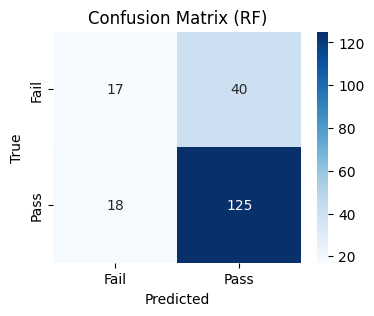

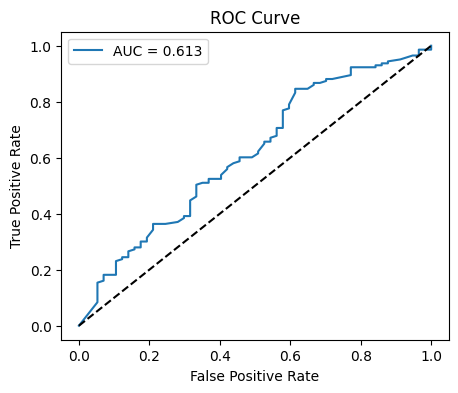

In [15]:
from sklearn.metrics import roc_curve

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail','Pass'], yticklabels=['Fail','Pass'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (RF)')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba_rf):.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Feature importance analysis

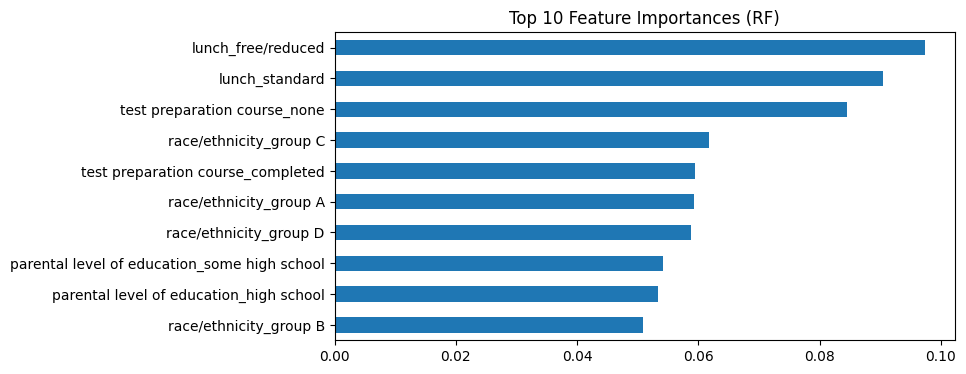

In [16]:
ohe = pipe_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_cols = ohe.get_feature_names_out(cat_features)
feature_names = ohe_cols

importances = pipe_rf.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(8,4))
feat_imp.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances (RF)')
plt.show()

Save model and test on a sample input

In [22]:
import joblib
joblib.dump(pipe_rf, 'student_pass_predictor_rf.pkl')

loaded = joblib.load('student_pass_predictor_rf.pkl')
sample = {
  'gender':'male',
  'race/ethnicity':'group A',
  'parental level of education':"some college",
  'lunch':'standard',
  'test preparation course':'completed'
}
sample_df = pd.DataFrame([sample])
print("Predicted probability of pass:", loaded.predict_proba(sample_df)[:,1][0])

Predicted probability of pass: 0.6423531746031744
